# Demo Notebook with simulated RGCs data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%load_ext memory_profiler
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import MEI
import matplotlib as mpl
from datetime import date
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. 

In [2]:
#Use dataloaders with generated RGC data
from lurz2020.datasets.mouse_loaders import static_loaders

path = ['D://inception_loop/RGC_sim_data/data/static27012021']

dataset_config = {'paths': path, 
                  'batch_size': 64,
                  'seed': 1,
                  'cuda': True,
                  'normalize': True, 
                  'exclude': "images"}

dataloaders_RGCs = static_loaders(**dataset_config)
dat = FileTreeDataset('D://inception_loop/RGC_sim_data/data/static27012021', "images", "responses")

In [3]:
tier = 'train'
dataset_name = '27012021'

### Look at the data

In [ ]:
tier = 'train'
dataset_name = '27012021'

images, responses = [], []
for data in dataloaders_RGCs[tier][dataset_name]:
    images.append(data[0].squeeze().cpu().data.numpy())
    responses.append(data[1].squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} RGC neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

In [ ]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# Build the model, transfer core, train and evaluate performance - 4 instances

Get 4 instances of the model for MEI generation:

In [ ]:
%%time 
%%memit
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles, get_FEV

#Generate 4 instances of the same model with different seeds, for MEI generation
n_seeds = 4

models = []
train_correlation_models, validation_correlation_models, test_correlation_models = [], [], []
fraction_oracle = []
exp_var_models = []
model_state_before, model_state_after = [], []

#Model config
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}


#Change trainer config to not track and print the training progress
trainer_config = {'track_training': False,
                  'verbose': None,
                  'detach_core': True}

#Save information on training
#with open("D://inception_loop/RGC_sim_data/models/Train_log_.txt", "a") as log_file:
#    comment = 'Comment: Results for tunned fullgaussian model with V1 core and readout trained with ephy data with only 2 good neurons with spatial rf. Shifter network used. Cropped images around rf location with padding.'
#    date = "Date: " + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
#    stim = "Stimuli dataset: " + dataset_name
#    model_config = "Model configuration: " + str(model_config_tunned)
#    log_file.write(comment+'\n'+date+'\n'+ stim+'\n'+model_config+'\n')
    
for i in range(n_seeds): 

    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=i)
    #Load the weights of the transfer core
    transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
    model.load_state_dict(transfer_model, strict=False)
    model_state_before.append(model.state_dict())
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    model_state_after.append(model.state_dict())
    #Get performance of model
    train_correlation_models.append(get_correlations(model, dataloaders_RGCs["train"], device='cuda', as_dict=False, per_neuron=False))
    validation_correlation_models.append(get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False))
    test_correlation_models.append(get_correlations(model, dataloaders_RGCs["test"], device='cuda', as_dict=False, per_neuron=False))
    
    oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
    fraction_oracle.append(get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0])
    exp_var_models.append(get_FEV(model, oracle_dataloader, device='cuda', as_dict=False, per_neuron=False, threshold=None))

    instance_results = '\n ----------------------------------------- \n \
    Model instance #{0:1d} \n \
    Correlation (train set):      {1:.3f} \n \
    Correlation (validation set): {2:.3f} \n \
    Correlation (test set):       {3:.3f} \n \
    ----------------------------------------- \n \
    Fraction oracle (test set):   {4:.3f} \n \
    FEV (test set): {5:.3f}  \n'.format(i, train_correlation_models[i], validation_correlation_models[i],
                                         test_correlation_models[i], fraction_oracle[i], exp_var_models[i])

    print(instance_results)
    
    #with open("D://inception_loop/RGC_sim_data/models/Train_log_.txt", "a") as log_file:
    #    log_file.write("\n Model instances training results: \n"+ instance_results)
        
    models.append(model)
    #Save model state for loading later
    #torch.save(model_state, 'D://inception_loop/RGC_sim_data/models/model_'+str(i)+'.pth')

In [ ]:
#Print results of after training step
results = '\n Results for fullgaussian tunned model: \n \
    ----------------------------------------- \n \
    {0:1d} instances of the model trained \n \
    Mean correlation (train set):      {1:.3f} \n \
    Mean correlation (validation set): {2:.3f} \n \
    Mean correlation (test set):       {3:.3f} \n \
    ----------------------------------------- \n \
    Mean fraction oracle (test set):   {4:.3f} \n \
    Mean FEV (test set): {5:.3f} \n '.format(len(train_correlation_models), np.mean(train_correlation_models),
    np.mean(validation_correlation_models), np.mean(test_correlation_models), np.mean(fraction_oracle), np.mean(exp_var_models))

print(results)

#Save in train log file
#with open("D://inception_loop/RGC_sim_data/models/Train_log_.txt", "a") as log_file:
#    log_file.write(results)

### Predict neural responses to an image (here from the train set)

In [ ]:
# show some example images and the neural responses
n_images = 10
max_response = responses[:n_images].max()

for i in range(n_images):
    input_image = images[i]
    fig, axs = plt.subplots(1, 6, figsize=(20,4))
    axs[0].imshow(input_image)
    axs[1].plot(responses[i])
    axs[1].set_title('real responses')
    
    for n in range(len(models)):

        predicted_response = models[n](torch.from_numpy(input_image).view(1,1,input_image.shape[0],input_image.shape[1]).cuda())
        predicted_response = predicted_response.squeeze().cpu().data.numpy()
        axs[n+2].plot(predicted_response)
        axs[n+2].set_xlabel('neurons')
        axs[n+2].set_title('predicted responses model '+str(n))
  

    plt.tight_layout()
    plt.show()

# Selection of neurons for MEI generation (use instead of padding the input images)

In [ ]:
%%time 
#Selection of neurons for MEI generation - 
#neurons with oracle correlation higher or equal to 0.9 and with similar predicted position of RF in the readout of the 4 models
from scipy.spatial.distance import pdist
from lurz2020.utility.measures import get_correlations, get_oracles

oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
oracle_corr = get_oracles(oracle_dataloader["test"], as_dict=False, per_neuron=True)
neurons_for_MEI_padded = []

for neuron in range(len(oracle_corr)):
    corr_models_neuron = []
    mu_positions_neuron = []
    for model in models:
        corr_models_neuron.append(get_correlations(model, dataloaders_RGCs["test"], device="cuda", as_dict=False, per_neuron=True)[neuron])
        mu_positions_neuron.append(model.readout[dataset_name].mu.cpu().detach().numpy()[0][neuron][0])
 
    if min(corr_models_neuron) >= 0.9 and max(pdist(mu_positions_neuron)) <= 0.15:
        neurons_for_MEI_padded.append(neuron)
        
np.save('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_model_diff_RFs.npy', neurons_for_MEI_padded)

In [ ]:
neurons_for_MEI_padded = np.load('D://inception_loop/RGC_sim_data/results/neurons_for_MEI_tunned_Fullgaussian.npy')

# MEI generation

In [4]:
#Load best tunned model instances - se2d_fullgaussian readout
from lurz2020.models.models import se2d_fullgaussian2d

n_seeds = 4

#Build model to load weights of instances 
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}

models = []
for n in range(n_seeds):
    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders_RGCs, seed=n)
    model_state = torch.load('D://inception_loop/RGC_sim_data/models/tunned_model_fullgaussian_corrected_'+str(n)+'.pth') 
    model.load_state_dict(model_state, strict=False)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    models.append(model)

In [5]:
#Parameters for MEI generation
MEIParameter_tunned = {
    #1000, 1.5, 0.01, 3.0, 0.125, 0.1, 0.1, 0, False, -1, 11.0)
    
    'iter_n' : 1000,         # int number of iterations to run
    'start_sigma' : 2.34,   # float starting sigma value
    'end_sigma'   : 0.16,     # float ending sigma value    
    'start_step_size' : 3.0,  # float starting step size  
    'end_step_size' : 0.125,  # float ending step size   
    'precond' : 0.13,          # float strength of gradient preconditioning filter falloff 
    'step_gain' : 0.1,      # float scaling of gradient steps
    'jitter' : 0,             # int size of translational jittering
    'blur' : True,            # bool whether to apply bluring or not 
    'norm' :  -1,             # float norm adjustment after step, negative to turn off
    'train_norm' : -1         # float norm adjustment during step, negative to turn off
    }

In [6]:
# Generate multi MEI object
MEIS = MEI.multi_MEI_class(dataset_name = dataset_name, dat = dat, dataloaders = dataloaders_RGCs, models = models, n_seeds = 4, MEIParameter = MEIParameter_tunned)

Working on neuron_id=0
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing


D:\inception_loop\ines_code\MEI.py:76: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  pp = torch.rfft(grad.data, 2, onesided=False)
D:\inception_loop\ines_code\MEI.py:77: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)
  return torch.irfft(pp * F, 2, onesided=False)


finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.16it/s]


Working on neuron_id=1
Working with images with mu=111.30036163330078, sigma=60.936492919921875
getting image size:
starting drawing
finished step 0 in octave 0
finished step 100 in octave 0
finished step 200 in octave 0
finished step 300 in octave 0
finished step 400 in octave 0
finished step 500 in octave 0
finished step 600 in octave 0
finished step 700 in octave 0
finished step 800 in octave 0
finished step 900 in octave 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.30it/s]


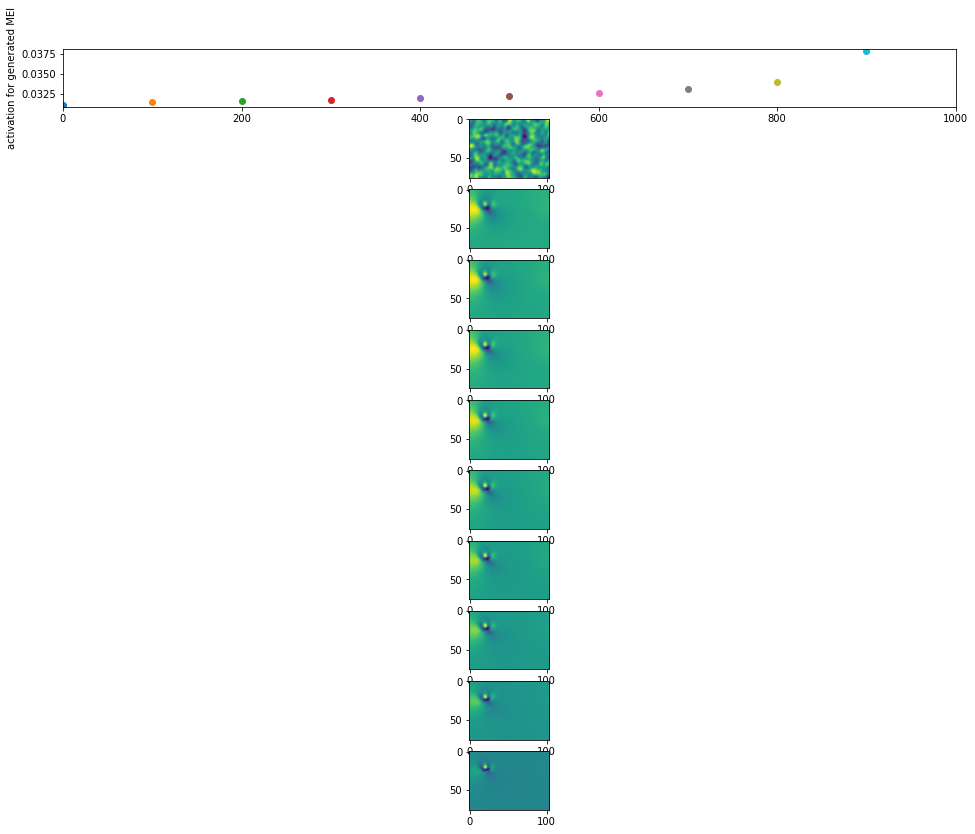

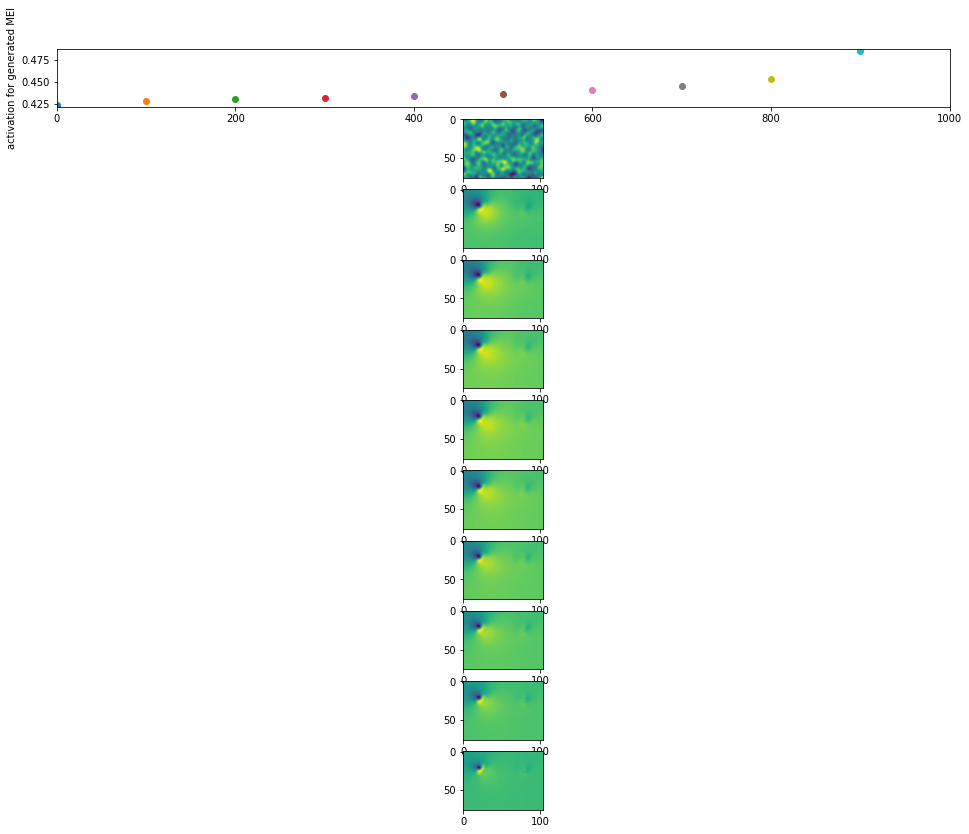

In [7]:
# Generate MEIs for target neurons from selected models
targets_list = range(2)
for target in targets_list:
    #Generate MEI for one target unit
    MEIS.generate(target, track=True)

In [9]:
target = 1
MEIS.MEIProperties

{'neuron_id : 0': {'n_seeds': 4,
  'mei': array([[129.94919818, 129.93190576, 129.89395578, ..., 128.50572434,
          128.50987401, 128.51223487],
         [129.97955525, 129.96441122, 129.92675726, ..., 128.50974325,
          128.51426158, 128.51706738],
         [130.039069  , 130.02764786, 129.99236385, ..., 128.51731981,
          128.52248829, 128.52601869],
         ...,
         [128.34302814, 128.34130653, 128.33792141, ..., 127.90719272,
          127.90780292, 127.90808985],
         [128.33835545, 128.33668105, 128.3333377 , ..., 127.90644633,
          127.90710555, 127.90744152],
         [128.33646312, 128.33489406, 128.33160882, ..., 127.90627743,
          127.9070202 , 127.90744515]]),
  'activation': 0.05390981,
  'monotonic': True,
  'max_activation': 0.053909793,
  'max_contrast': 6.253959603889481,
  'sat_contrast': 6.253959603889481,
  'img_mean': 128.1465976726011,
  'lim_contrast': 7.449567920967535},
 'neuron_id : 1': {'n_seeds': 4,
  'mei': array([[117.461

In [ ]:
#Plot generated MEI 
for TargetUnit in  targets_list:
    mei_target = MEIS.MEIProperties['neuron_id : '+str(TargetUnit)]['mei']

    fig, axs = plt.subplots(1, figsize=(15,4))
    axs.imshow(mei_target[20:56, 20:84])
    axs.set_title('MEI unit '+str(TargetUnit))
    rf = np.load('D://inception_loop/RGC_sim_data/data/static'+dataset_name+'/RFs/'+str(TargetUnit)+'.npy')
    axs[1].imshow(rf)
    axs[1].set_title("RGC RF")

    #plt.tight_layout()
    plt.savefig('D://inception_loop/RGC_sim_data/results/MEI_unit_'+str(TargetUnit)+'_model_.png')

In [ ]:
# Save generated MEIS
import pickle 
info_to_save_MEIS = {'dataset_name': MEIS.dataset_name,
                      'models': MEIS.models,
                      'n_seeds': MEIS.n_seeds,
                      'MEIParameter': MEIS.MEIParameter,
                      'MEIProperties': MEIS.MEIProperties}

with open('D://inception_loop/RGC_sim_data/results/MEIS_model_.pkl', 'wb') as file:
    pickle.dump(info_to_save_MEIS, file, pickle.HIGHEST_PROTOCOL)

--------------------------------

# STA of modeled responses

In [ ]:
%%time
#Probe to select lower and upper bound of the rcond values
from scipy import linalg

rcond = 3000
n_seeds = 4
targets_list = [0,1]
        
for neuron in targets_list:
    
    predicted_responses = []
    for i in range(len(images)):
        predicted_response_models = []
        for seed in range(n_seeds):
            predicted_response = models[seed](torch.from_numpy(images[i]).view(1,1,76,104).cuda())
            predicted_response_models.append(predicted_response.squeeze().cpu().data.numpy()[neuron])
        predicted_responses.append(np.mean(predicted_response_models))

    S = []
    for i in range(len(images)):
        image = images[i].ravel()
        S.append(image)
    S = np.array(S)
    
    pseudo_inv = linalg.pinv2(S, rcond)
    sta = np.dot(pseudo_inv, predicted_responses)
    sta_neurons_decorr = (sta/sum(predicted_responses)).reshape(76,104)
    sta_neurons = (np.dot(S.T, predicted_responses)/sum(predicted_responses)).reshape(76,104)

    fig, ax = plt.subplots(1, figsize=(15,4))
    plt.imshow(sta_neurons_decorr[20:56,20:84])
    plt.title('STA decorr of target unit '+str(neuron)+' with natural stimuli (rcond='+str(rcond)+')')
    plt.savefig("D://inception_loop/RGC_sim_data/results/STA_decorr_unit_"+str(neuron)+"_tunned_model_fullgaussian_ephy_data_v4.png")
    plt.close()

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,7))
plt.imshow(sta_neurons[20:56,20:84])
plt.title('STA of target unit '+str(neuron)+' with natural stimuli')
#plt.savefig("D://inception_loop/RGC_sim_data/results/STA_natur_target_unit_"+str(neuron)+".png")

---------------------

# STA of true responses

In [ ]:
images[0].shape

In [ ]:
from scipy import linalg
rcond = 2500

neuron = 0
response = responses[:,neuron]

S = []
for i in range(len(images)):
    image = images[i].ravel()
    S.append(image)
S = np.array(S)
        
#pseudo_inv = linalg.pinv2(S, rcond)
#sta = np.dot(pseudo_inv, response)
#sta_neurons_decorr = (sta/sum(response)).reshape(76,104)
sta_neurons = (np.dot(S.T, response)/sum(response)).reshape(76,104)

fig, ax = plt.subplots(1, figsize=(7,7))
plt.imshow(sta_neurons)
plt.title('STA decorr of unit '+str(neuron)+' with ephy responses (rcond='+str(rcond)+')')

In [ ]:
from scipy import linalg
rcond = 4800

for neuron in range(len(responses[0,:])):

    response = responses[:,neuron]

    S = []
    for i in range(len(images)):
        image = images[i].ravel()
        S.append(image)
    S = np.array(S)
        
    pseudo_inv = linalg.pinv2(S, rcond)
    sta = np.dot(pseudo_inv, response)
    sta_neurons_decorr = (sta/sum(response)).reshape(36,64)
    sta_neurons = (np.dot(S.T, response)/sum(response)).reshape(36,64)

    fig, ax = plt.subplots(1, figsize=(7,7))
    plt.imshow(sta_neurons_decorr)
    plt.title('STA decorr of unit '+str(neuron)+' with ephy responses (rcond='+str(rcond)+')')
    plt.savefig("D://inception_loop/RGC_sim_data/results/STA_decorr_unit_"+str(neuron)+"_ephy_responses.png")
    plt.close()

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,7))
plt.imshow(sta_neurons_decorr)
plt.title('STA decorr of target unit '+str(neuron)+' with natural stimuli (rcond='+str(rcond)+')')
#plt.savefig("D://inception_loop/RGC_sim_data/results/STA_decorr_unit_"+str(neuron)+"_ephy.png")

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,7))
plt.imshow(sta_neurons)
plt.title('STA of target unit '+str(neuron)+' with natural stimuli')
#plt.savefig("D://inception_loop/RGC_sim_data/results/STA_natur_target_unit_"+str(neuron)+".png")

-------------------

In [ ]:
torch.cuda.empty_cache()

-----------------------------